Taller 2 

* Nombre: Carlos Felipe Niño Rodríguez.
* Email: [cfnino@unbosque.edu.co](mailto:cfnino@unbosque.edu.co)
* Big Data Analytics.
* Profesor: Fabian Peña.
* Universidad el bosque.

## Parte 1:

In [20]:
# Importing required libraries

import time

from bs4 import BeautifulSoup
from selenium import webdriver

from pymongo import MongoClient

Conexión a MongoDB:

In [21]:
# Creating a connection to MongoDB
client = MongoClient('localhost', 27017)
db = client['news']
collection = db['elespectador']

Proceso para abrir el explorador:

In [22]:
# Base URL of the site to be analyzed
SITE_URL = 'https://www.elespectador.com'

In [23]:
# Firefox web driver path
# Download the driver for you S.O. here: https://github.com/mozilla/geckodriver/releases
DRIVER_PATH = './geckodriver.exe'

In [24]:
# Creating a new firefox window
browser = webdriver.Firefox(executable_path = DRIVER_PATH)

In [25]:
def make_request(browser, relative_path):
    # Making the request and rendering the browser
    browser.get(SITE_URL + relative_path)
    
    # Simulating vertical scrolling for handling lazy load
    check_height = browser.execute_script('return document.body.scrollHeight;')
    while True:
        browser.execute_script('window.scrollTo(0, document.body.scrollHeight);')
        time.sleep(3)
        height = browser.execute_script('return document.body.scrollHeight;')
        if height == check_height: 
            break 
        check_height = height
    
    # Getting HTML content and passing it to BeautifulSoup for scraping analysis
    return BeautifulSoup(browser.page_source, 'html.parser')

In [28]:
# "politica","judicial","investigacion",
categorias = ["bogota","mundo"]
for i in range(0, len(categorias)):
    for j in range(1,2): #For para avanzar páginas
        news = []
        soup = make_request(browser, '/archivo/'+categorias[i]+'/'+str(j))
        # Finding the section where news are contained 
        layout = soup.find(class_ = 'Layout-flexAds')
        # Getting blocks from layout
        blocks = layout.find('section').find_all(recursive = False)
        # 3 blocks founded, 2 for news and 1 for pagination
        cards = blocks[0].find_all(class_ = 'Card') + blocks[1].find_all(class_ = 'Card')
        for card in cards:
            news.append({
            'title': card.find('h2', class_ = 'Card-Title').find('a').get_text(),
            'relative_path': card.find('h2', class_ = 'Card-Title').find('a')['href']
            })
        for n in news:
            # Getting HTML content for news page
            soup = make_request(browser, n['relative_path'])
    
            # Extracting news metadata
            try:
                n['datetime'] = soup.find(class_ = 'ArticleHeader-Date').get_text()
            except:
                n['datetime'] = ""
                
            n['category'] = categorias[i]
            try:
                n['categorynew'] = soup.find(class_ = 'ACredit-Hook').get_text()
            except:
                n['categorynew'] = ""
            try:
                n['author'] = soup.find(class_ = 'ACredit-Author').find('a').get_text()
            except:
                n['author'] = ""
            try:
                n['summary'] = soup.find(class_ = 'ArticleHeader-Hook').find('div').get_text()
            except:
                n['summary'] = soup.find(class_ = 'ArticleHeader-Hook').get_text()
    
            # Extracting and concatenating news full text
            paragraphs = soup.find_all(class_ = 'font--secondary')
            n['full_text'] = ' '.join([p.get_text() for p in paragraphs])
        collection.insert_many(news)

### Evidencia MongoDB:

Por si acaso, en la carpeta Screenshots del repositorio se encuentra la imagen.

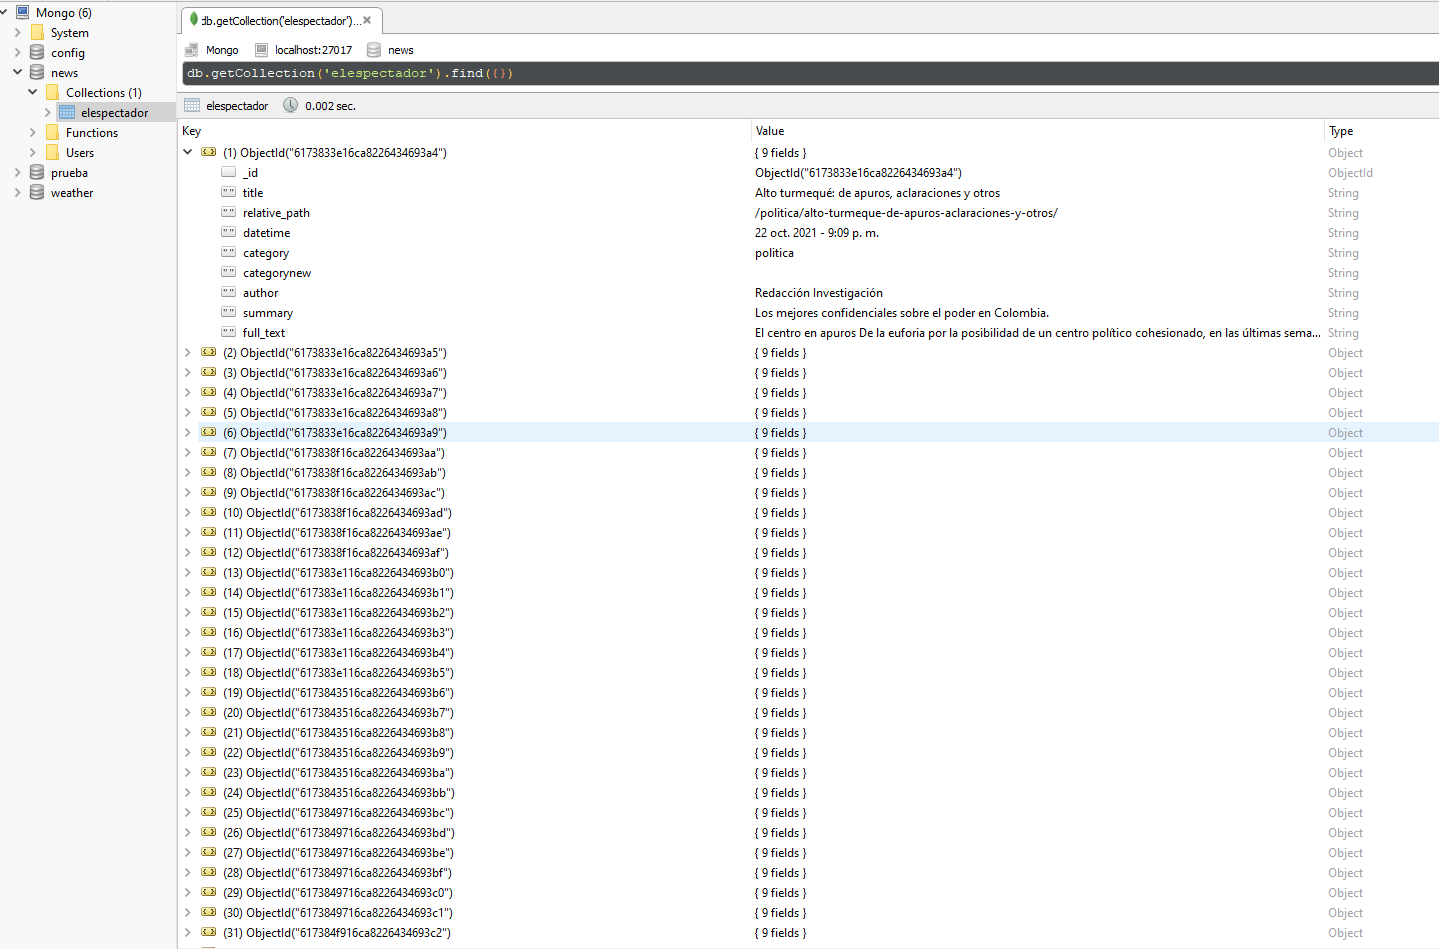

## Parte 2:

In [29]:
!pip install wordcloud

In [30]:
import os

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tag import StanfordPOSTagger

from wordcloud import WordCloud

from pymongo import MongoClient

import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
# Creating a connection to MongoDB
client = MongoClient("localhost", 27017)
db = client["news"]
collection = db["elespectador"]

### Todo el dataset:

In [32]:
text = []
for news in list(collection.find({}, {"title": 1, "summary": 1, "full_text": 1, "_id": 0})):
    text.append(news["title"])
    text.append(news["summary"])
    text.append(news["full_text"])

#### Texto

In [33]:
text = " ".join(text)
print(text)

Alto turmequé: de apuros, aclaraciones y otros Los mejores confidenciales sobre el poder en Colombia. El centro en apuros De la euforia por la posibilidad de un centro político cohesionado, en las últimas semanas se ha pasado a una realidad contundente: el centro está roto por dentro. La Coalición de la Esperanza no despega, Humberto de la Calle ya no sabe si encabezar mejor una lista al Senado, Sergio Fajardo anda agobiado con el caso Hidroituango, parece que Alejandro Gaviria no quiere ser recibido por los verdes y el expresidente César Gaviria mueve sus fichas en la tras escena. Fajardo está muy incómodo con el abrazo de Gaviria a Alejandro, que este último no reconoce públicamente pero que necesita a la sombra porque ya hay una maquinaria detrás. Y Fajardo está más molesto aún con el contralor Carlos Felipe Córdoba, a quien relaciona como hombre muy cercano a César Gaviria. Mientras todo esto ocurre, la derecha se alinea mejor, como siempre pasa. “Estamos retomando banderas nuestra

#### Minúscula y  Tokenization

In [34]:
# Lowercasing
text = text.lower() 
#Tokenization
nltk.download('punkt')
sentences = sent_tokenize(text)
words = word_tokenize(text)
print(sentences)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fnino\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['alto turmequé: de apuros, aclaraciones y otros los mejores confidenciales sobre el poder en colombia.', 'el centro en apuros de la euforia por la posibilidad de un centro político cohesionado, en las últimas semanas se ha pasado a una realidad contundente: el centro está roto por dentro.', 'la coalición de la esperanza no despega, humberto de la calle ya no sabe si encabezar mejor una lista al senado, sergio fajardo anda agobiado con el caso hidroituango, parece que alejandro gaviria no quiere ser recibido por los verdes y el expresidente césar gaviria mueve sus fichas en la tras escena.', 'fajardo está muy incómodo con el abrazo de gaviria a alejandro, que este último no reconoce públicamente pero que necesita a la sombra porque ya hay una maquinaria detrás.', 'y fajardo está más molesto aún con el contralor carlos felipe córdoba, a quien relaciona como hombre muy cercano a césar gaviria.', 'mientras todo esto ocurre, la derecha se alinea mejor, como siempre pasa.', '“estamos retoma

#### Stop_words:

In [35]:
nltk.download('stopwords')
stop_words = set(stopwords.words("spanish"))
print(stop_words)

{'tuviera', 'tuvieseis', 'habrías', 'nosotros', 'e', 'eres', 'nuestras', 'tenían', 'muy', 'ni', 'sois', 'fuésemos', 'habríais', 'teníais', 'fui', 'tenga', 'ese', 'él', 'estéis', 'estaría', 'tenida', 'tuyos', 'habremos', 'seríamos', 'tenía', 'te', 'seremos', 'estuviste', 'su', 'tuvo', 'ellas', 'tuvisteis', 'estad', 'habida', 'estuvieses', 'mi', 'un', 'no', 'el', 'habría', 'estuvo', 'somos', 'más', 'suyos', 'estaríais', 'he', 'tened', 'nos', 'esa', 'estoy', 'estuvieras', 'mía', 'como', 'tuya', 'tengo', 'fueras', 'suyo', 'hubimos', 'estuvierais', 'hubieran', 'estuve', 'tienen', 'hubiese', 'estabais', 'ya', 'habéis', 'nosotras', 'sintiendo', 'tuviesen', 'algo', 'esas', 'estés', 'eso', 'fueran', 'estaba', 'otros', 'sentidos', 'les', 'sentid', 'hayan', 'a', 'todos', 'este', 'tuve', 'esto', 'estarán', 'tendríais', 'siente', 'tuvieras', 'y', 'durante', 'tu', 'unos', 'estuviesen', 'hubieses', 'ellos', 'ti', 'tus', 'nuestros', 'se', 'estuvieseis', 'tendrías', 'antes', 'es', 'hubo', 'hemos', 'fue

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fnino\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
filtered_words = []
for w in words:
    if w not in stop_words:
        filtered_words.append(w)

print("All words:", words)
print("\n")
print("Substracting stopwords:", filtered_words)

All words: ['alto', 'turmequé', ':', 'de', 'apuros', ',', 'aclaraciones', 'y', 'otros', 'los', 'mejores', 'confidenciales', 'sobre', 'el', 'poder', 'en', 'colombia', '.', 'el', 'centro', 'en', 'apuros', 'de', 'la', 'euforia', 'por', 'la', 'posibilidad', 'de', 'un', 'centro', 'político', 'cohesionado', ',', 'en', 'las', 'últimas', 'semanas', 'se', 'ha', 'pasado', 'a', 'una', 'realidad', 'contundente', ':', 'el', 'centro', 'está', 'roto', 'por', 'dentro', '.', 'la', 'coalición', 'de', 'la', 'esperanza', 'no', 'despega', ',', 'humberto', 'de', 'la', 'calle', 'ya', 'no', 'sabe', 'si', 'encabezar', 'mejor', 'una', 'lista', 'al', 'senado', ',', 'sergio', 'fajardo', 'anda', 'agobiado', 'con', 'el', 'caso', 'hidroituango', ',', 'parece', 'que', 'alejandro', 'gaviria', 'no', 'quiere', 'ser', 'recibido', 'por', 'los', 'verdes', 'y', 'el', 'expresidente', 'césar', 'gaviria', 'mueve', 'sus', 'fichas', 'en', 'la', 'tras', 'escena', '.', 'fajardo', 'está', 'muy', 'incómodo', 'con', 'el', 'abrazo', '

#### Nube de palabras:

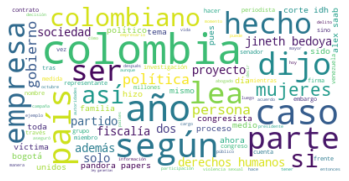

In [37]:
wordcloud = WordCloud(max_font_size = 50, max_words = 100, background_color = "white").generate(" ".join(filtered_words))

plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

### Categorías de temas:

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fnino\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fnino\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Nube de palabras para el tema: politica 


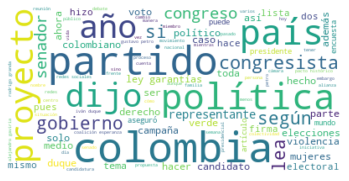

In [42]:
nltk.download('punkt')
nltk.download('stopwords')

text = []
for news in list(collection.find({'category': 'politica'}, {'_id': 0, 'datetime': 0, 'author': 0})):
    text.append(news["title"])
    text.append(news["summary"])
    text.append(news["full_text"])
# Texto    
text = " ".join(text)
# Minúscula 
text = text.lower()
# Tokenization
sentences = sent_tokenize(text)
words = word_tokenize(text)
# Stop_words
stop_words = set(stopwords.words("spanish"))
filtered_words = []
for w in words:
    if w not in stop_words:
        filtered_words.append(w)
# Nube de palabras
print("Nube de palabras para el tema: politica ")
wordcloud = WordCloud(max_font_size = 50, max_words = 100, background_color = "white").generate(" ".join(filtered_words))

plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()
        

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fnino\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fnino\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Nube de palabras para el tema: judicial 


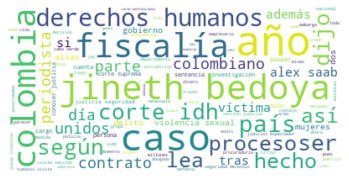

In [43]:
nltk.download('punkt')
nltk.download('stopwords')

text = []
for news in list(collection.find({'category': 'judicial'}, {'_id': 0, 'datetime': 0, 'author': 0})):
    text.append(news["title"])
    text.append(news["summary"])
    text.append(news["full_text"])
# Texto    
text = " ".join(text)
# Minúscula 
text = text.lower()
# Tokenization
sentences = sent_tokenize(text)
words = word_tokenize(text)
# Stop_words
stop_words = set(stopwords.words("spanish"))
filtered_words = []
for w in words:
    if w not in stop_words:
        filtered_words.append(w)
# Nube de palabras
print("Nube de palabras para el tema: judicial ")
wordcloud = WordCloud(max_font_size = 50, max_words = 100, background_color = "white").generate(" ".join(filtered_words))

plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fnino\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fnino\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Nube de palabras para el tema: investigacion 


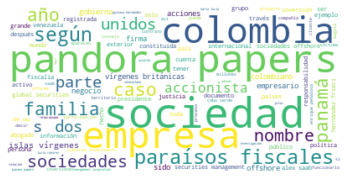

In [44]:
nltk.download('punkt')
nltk.download('stopwords')

text = []
for news in list(collection.find({'category': 'investigacion'}, {'_id': 0, 'datetime': 0, 'author': 0})):
    text.append(news["title"])
    text.append(news["summary"])
    text.append(news["full_text"])
# Texto    
text = " ".join(text)
# Minúscula 
text = text.lower()
# Tokenization
sentences = sent_tokenize(text)
words = word_tokenize(text)
# Stop_words
stop_words = set(stopwords.words("spanish"))
filtered_words = []
for w in words:
    if w not in stop_words:
        filtered_words.append(w)
# Nube de palabras
print("Nube de palabras para el tema: investigacion ")
wordcloud = WordCloud(max_font_size = 50, max_words = 100, background_color = "white").generate(" ".join(filtered_words))

plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fnino\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fnino\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Nube de palabras para el tema: bogota 


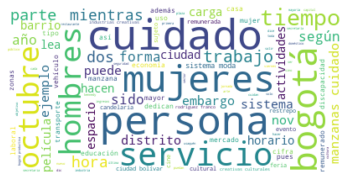

In [45]:
nltk.download('punkt')
nltk.download('stopwords')

text = []
for news in list(collection.find({'category': 'bogota'}, {'_id': 0, 'datetime': 0, 'author': 0})):
    text.append(news["title"])
    text.append(news["summary"])
    text.append(news["full_text"])
# Texto    
text = " ".join(text)
# Minúscula 
text = text.lower()
# Tokenization
sentences = sent_tokenize(text)
words = word_tokenize(text)
# Stop_words
stop_words = set(stopwords.words("spanish"))
filtered_words = []
for w in words:
    if w not in stop_words:
        filtered_words.append(w)
# Nube de palabras
print("Nube de palabras para el tema: bogota ")
wordcloud = WordCloud(max_font_size = 50, max_words = 100, background_color = "white").generate(" ".join(filtered_words))

plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fnino\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fnino\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Nube de palabras para el tema: mundo 


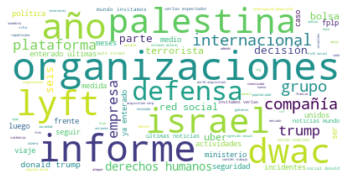

In [46]:
nltk.download('punkt')
nltk.download('stopwords')

text = []
for news in list(collection.find({'category': 'mundo'}, {'_id': 0, 'datetime': 0, 'author': 0})):
    text.append(news["title"])
    text.append(news["summary"])
    text.append(news["full_text"])
# Texto    
text = " ".join(text)
# Minúscula 
text = text.lower()
# Tokenization
sentences = sent_tokenize(text)
words = word_tokenize(text)
# Stop_words
stop_words = set(stopwords.words("spanish"))
filtered_words = []
for w in words:
    if w not in stop_words:
        filtered_words.append(w)
# Nube de palabras
print("Nube de palabras para el tema: mundo ")
wordcloud = WordCloud(max_font_size = 50, max_words = 100, background_color = "white").generate(" ".join(filtered_words))

plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

### Término de búsqueda:

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fnino\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fnino\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Nube de palabras:


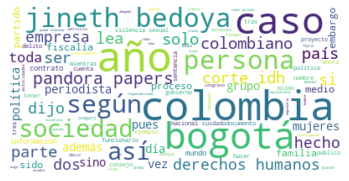

In [48]:
from pymongo import TEXT
nltk.download('punkt')
nltk.download('stopwords')

collection.create_index([('title', TEXT), ('summary', TEXT), ('full_text', TEXT)], default_language = 'spanish')

text = []
for news in list(collection.find({'$text': {'$search': 'Bogota'}}, {'_id': 0, 'summary': 1, 'title': 1, 'full_text': 1})):
    text.append(news["title"])
    text.append(news["summary"])
    text.append(news["full_text"])
# Texto    
text = " ".join(text)
# Minúscula 
text = text.lower()
# Tokenization
sentences = sent_tokenize(text)
words = word_tokenize(text)
# Stop_words
stop_words = set(stopwords.words("spanish"))
filtered_words = []
for w in words:
    if w not in stop_words:
        filtered_words.append(w)
# Nube de palabras
print("Nube de palabras:")
wordcloud = WordCloud(max_font_size = 50, max_words = 100, background_color = "white").generate(" ".join(filtered_words))

plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()